
# Supervised learning and backprop in the brain [week 4,5]

This lab follows **lecture 2** of the second part of IPB. We are going explore supervised learning with the use of backprop<sup>1</sup> as a potential model for credit assignment in the brain. In the first part, we will ask you to implement standard backprop for a simple task. In the second part, you will test the different issues of that exist with backprop in terms of biological plausibility.


<span style="color:gray"><sup>1</sup> Note that backprop is not specific to superviser learning, it is a general optimisation algorithm to assign credit that can be also used in unsupervised and reinforcement learning.</span>

# 1. Implementing backpropagation 

## 1.1 Intro

In this first part we will solve a *supervised learning task* using an artificial neural network. Recall that in supervised learning we want to learn a mapping between some given input values $\mathbf{u}$ and an output value $v$. We generally call $\mathbf{u}$ the *features* of a given example, whereas $v$ is the respective $target$. A key assumption of supervised learning is that there exists a dataset $\mathcal{D}$, provided by some external 'teacher', full of feature-target pairs $(\mathbf{u}_i, v_i)_{i=1}^N$ for some dataset size $N$. 

Given a large enough $N$ neural networks can be trained very succesfully to predict target values for previously unseen feature vectors. The key algorithm for training, used widely in the machine learning world, is *backpropogation*. 

<div>
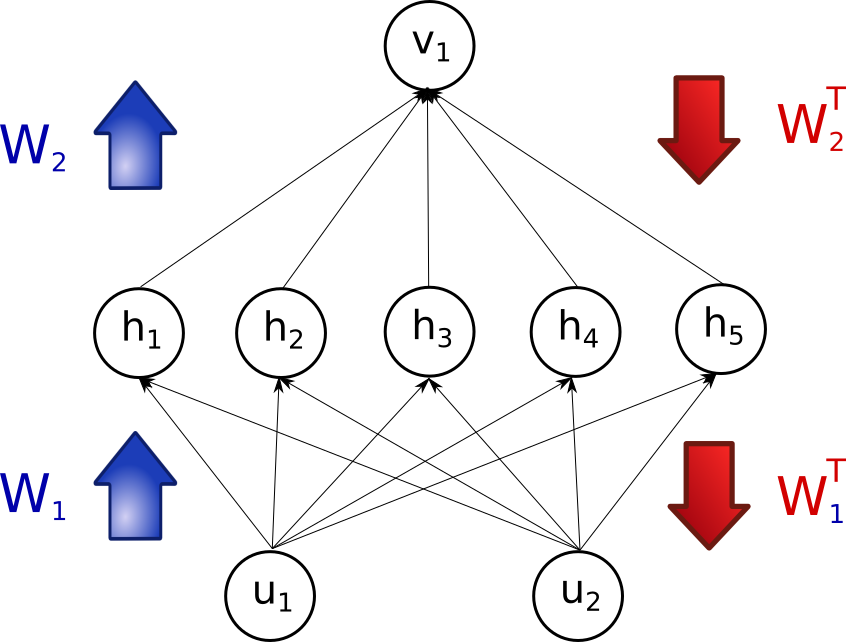
</div>

Here we are going to train a neural network of one hidden layer to compute different logic gates; in particular, the <span style="font-variant:small-caps;">AND, OR, XOR, XNOR</span> gates. Each of these gates take as input two logical values (0 or 1), A and B, and combines them to form some logical output. The table of outputs for each possible A, B combination for each gate is shown below.

| A | B | AND | OR | XOR | XNOR |
| - | - | - | - | - | - |
| 0 | 0 |0| 0 | 0 | 1 |
| 0 | 1 |0| 1 | 1 | 0 |
| 1 | 0 | 0 | 1 | 1 | 0 |
| 1 | 1 | 1 | 1 | 0 | 1 |



Training such a neural network to solve these logical computations is only part of the task. Remember, we want to understand information processing *in the brain*. It is important to ask yourself questions such as 'how does this compare with the real brain?', 'are there any differences/limitations in learning and performance of the artificial model with respect to biology'? As a particular focus we will consider backpropogation as a means of learning. Useful articles on this subject have been written by [Blake and Lillicrap](https://www.sciencedirect.com/science/article/pii/S0959438818300485) and [Sacramento et al.](http://papers.neurips.cc/paper/8089-dendritic-cortical-microcircuits-approximate-the-backpropagation-algorithm.pdf) and might help you to reflect.

## 1.2 Importing libraries

First we will import the necessary libraries. To encourage a concrete understanding of the mathematical computations involved in training a neural network, we will refrain from using specialised machine learning libraries (e.g. pytorch) and perform any array computations ourselves using the numpy library. For any plotting we will use matplotlib. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1.3 Setting up the datasets
We need to define the datasets. This isn't too hard, since there are only 4 distinct input possibilities (see table above). We will represent the dataset as a list of possible $(\mathbf{u}, v)$ using the terminology above. The dataset for the AND operator is already written for you. Your first task is to write datasets defined by the OR, XOR and XNOR operators. 

In [2]:
#the dataset defined by the logical operator AND
dataset_and = [
                ([0, 0], 0),
                ([0, 1], 0),
                ([1, 0], 0),
                ([1, 1], 1)
                ]

#the dataset defined by the logical operator OR
dataset_or = [
                ([0, 0], 1),
                ([0, 1], 1),
                ([1, 0], 1),
                ([1, 1], 0)
                ]

#the dataset defined by the logical operator XOR
dataset_xor = [
                ([0, 0], 0),
                ([0, 1], 1),
                ([1, 0], 1),
                ([1, 1], 0)
                ]

#the dataset defined by the logical operator XNOR
dataset_xnor = [
                ([0, 0], 1),
                ([0, 1], 0),
                ([1, 0], 0),
                ([1, 1], 1)
                ]

Typically in machine learning examples are not presented to the model one by one but in batches. For large datasets this can significantly improve the speed of learning, since we're effectively replacing for loops by highly optimised array operations. In the case of this task we have very small datasets so we don't necessarily need to learn in batches. Even so, it's a good habit to write code compatible with flexible batch sizes. For this reason we'll now define a 'generate_batch' method which will take in a user-specified dataset and batch_size before returning a batch of appropriate examples. 

In [3]:
#Batch generation. Given a dataset D and batch_size N, this method 
#will produce N random examples from D. The output will be a tuple
#of ordered arrays (inputs, targets), so that targets[i] is the 
#associated target for inputs[i]
def generate_batch(dataset, batch_size):
    #differentiate inputs (features) from targets and transform each into 
    #numpy array with each row as an example
    inputs = np.vstack([ex[0] for ex in dataset])
    targets = np.vstack([ex[1] for ex in dataset])
    
    #randomly choose batch_size many examples; note there will be
    #duplicate entries when batch_size > len(dataset) 
    rand_inds = np.random.randint(0, len(dataset), batch_size)
    inputs_batch = inputs[rand_inds]
    targets_batch = targets[rand_inds]
    
    return inputs_batch, targets_batch
    

We can now easily generate batches for any of the datasets defined above. As an example, to obtain 100 examples out of the XOR dataset, we just run

In [4]:
inputs_xor, targets_xor = generate_batch(dataset_xor, batch_size=100)

## 1.4 Initialising the network
We now design our neural network of one hidden layer. It is easy to get mixed up when dealing with the various details and computations of neural networks so clear, intepretable code is a must. We will implement ours in a similar fashion to the implementation in [Pytorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). That is, we will define a class *nn_one_layer* which initialises according to several important neural network hyperparameters: input_size (the dimension of the input to the network), hidden_size (the hidden dimension, i.e. the number of hidden units/'neurons' in the network) and target_size (the required output dimension of the network).

These hyperparameters will define the dimensions of the weights of the neural network. In this case we will only have two weights, $W_1$ and $W_2$. Given an example feature vector $\mathbf{w}$ the output, or 'prediction' $v$ of the network is
\begin{align}
\mathbf{h} &= f(\mathbf{u}W_1) \\
\hat{v} &= \mathbf{h}W_2
\end{align}

Where $\mathbf{h}$ is the 'hidden activity' of the network and $f$ is usually some non-linearity. In this task we will take $f$ to be the sigmoid function, i.e., $f(a) =\frac{1}{1+e^{-a}}$. Because the target dimension is often one in machine learning problems (and as for this task), we can just use a scalar for the network output $y$. 

Note that due to the nature of matrix multiplication the above equations can easily handle a batch $\mathbf{U}$. For example, let $b_s$ denote the batch size, and $i_s$, $h_s$ and $o_s$ the input, hidden and output size respectively. Now we can write the dimension of the input matrix $\mathbf{U}$ as $(b_s, i_s)$. The equations for the 'batch hidden activity' $\mathbf{H}$ and 'batch output' $\mathbf{v}$ is just the same as before

\begin{align}
\mathbf{H} &= f(\mathbf{U}W_1) \\
\hat{\mathbf{v}} &= \mathbf{H}W_2
\end{align}

For reasons that will become apparent later, it will also be useful to consider the helper variable $\mathbf{Z}$ where $\mathbf{Z} = \mathbf{U}W_1$ and so $\mathbf{H} = f(\mathbf{z})$.

*Quick question to check understanding*: what are the dimensions of the matrices $\mathbf{H}$ and $\hat{\mathbf{v}}$ in terms of $i_s$, $h_s$, $o_s$ and $b_s$? What are the dimensions of the weight matrices $W_1$ and $W_2$?

We will now write code for *nn_one_layer* which initiliases the model and also defines the forward computation. Note that appropriately initiliasing weights can actually be a more difficult task [than it seems](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). Here, we will initialise each weight randomly according to a normal distribution of standard deviation $\sigma = 0.1$. As before, your job is to fill in any part with 'TODO'. 

In [5]:
def sigmoid(a):
    siga = 1/(1 + np.exp(-a))
    return siga
    

class nn_one_layer():
    def __init__(self, input_size, hidden_size, output_size):
        #define the input/output weights W1, W2
        self.W1 = 0.1 * np.random.randn(input_size, hidden_size)
        self.W2 = 0.1 * np.random.randn(hidden_size, output_size)
        
        self.f = sigmoid
    
    def forward(self, u):
        z = np.matmul(u, self.W1)
        h = self.f(z)
        v = np.matmul(h, self.W2)
        return v, h, z
        
        
        

You should now be able to initialise your model and check it can perform a batch computation on the datasets defined above. Fill in the 'TODO's below to view a histogram of output values for the XOR dataset as predicted by an untrained neural network of 5 hidden neurons.

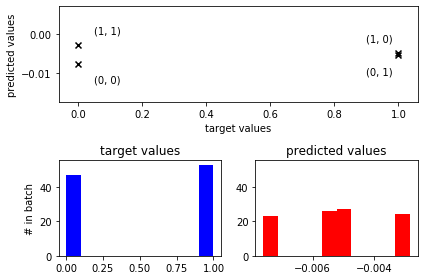

In [6]:
input_size = 2
hidden_size = 5
output_size = 1

nn = nn_one_layer(input_size, hidden_size, output_size) #initialise model
preds_xor, _, _ = nn.forward(inputs_xor) #prediction made by model on batch xor input

_, inds = np.unique(inputs_xor, return_index=True, axis=0)


# plot target vs predictions along with a histogram of each
fig = plt.figure()
ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=2)
plt.scatter(targets_xor[inds], preds_xor[inds], marker='x', c='black')
for i in inds:
    coord = '({}, {})'.format(inputs_xor[i][0], inputs_xor[i][1])
    xoffset = 0.05 if targets_xor[i] == 0 else -0.1
    yoffset = 0.003 if preds_xor[i] > np.mean(preds_xor[inds]) else -0.005
    plt.text(targets_xor[i] + xoffset, preds_xor[i] + yoffset, coord)
plt.xlabel('target values')
plt.ylabel('predicted values')
plt.ylim([np.min(preds_xor) - 0.01, np.max(preds_xor) + 0.01])
ax2 = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
plt.hist(targets_xor, color='blue')
ax2.set_title('target values')
plt.ylabel('# in batch')
ax3 = plt.subplot2grid((2,2), (1,1), rowspan=1, colspan=1, sharey=ax2)
plt.hist(preds_xor, color='red')
ax3.set_title('predicted values')

fig.tight_layout()


If you managed to generate the plot, hopefully you see that the network as it is pretty useless! It doesn't get near the required target values according to the true XOR operator, let alone understanding that it should only produce logical output vaues of 0 or 1. 

The expectation is that, with a good learning procedure to train the weights $W_1$ and $W_2$, we should be able to produce a network which much better captures XOR, or indeed any other logical gate we fancy.

## 1.5 Backpropagating gradients
In this section we will write code to compute loss gradients with backpropagation. Recall that backpropagation takes advantage of the chain rule. Suppose that some loss function $\mathcal{L}$ exists which depends on the network output. For an arbitrary sequence of hidden activities $\mathbf{u}=\mathbf{h}_0, \mathbf{h}_1, \dots, \mathbf{h}_i, \dots, \mathbf{h_N}=\hat{\mathbf{v}}$ and inbetween weights $W_1, W_2, \dots, W_N$  

\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{h}_i} &= \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{i+1}} \frac{\partial \mathbf{h}_{i+1}}{\partial \mathbf{h}_{i}} \\
\frac{\partial \mathcal{L}}{\partial W_i} &= \frac{\partial \mathcal{L}}{\partial \mathbf{h}_i} \frac{\partial \mathbf{h}_i}{\partial W_i}
\end{align}

Note that these partial derivatives are with respect to vectors and are therefore [Jacobian matrices](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant). Explicitly computing the above equations in our case can be greatly helped with certain rules for matrix multiplication and arbtitrary (non-linear) functions. These rules are the following.

\begin{align}
C&=A B \Rightarrow \frac{\partial \mathcal{L}}{\partial A}=\frac{\partial \mathcal{L}}{\partial C} B^{\top} \text { and } \frac{\partial \mathcal{L}}{\partial B}=A^{\top} \frac{\partial \mathcal{L}}{\partial C} \\
C&=g(A) \Rightarrow \frac{\partial \mathcal{L}}{\partial A}=g^{\prime}(A) \odot \frac{\partial \mathcal{L}}{\partial C}
\end{align}

For any matrices $A, B, C$, where $\odot$ is the element wise product, i.e. $(A \odot B)_{ij} = A_{ij} \times B_{ij}$, and $g$ is an arbitrary function. There is some abuse in notation here: we assume $\frac{\partial \mathcal{L}}{\partial A}$ itself be a matrix of the same size as $A$ so that $(\frac{\partial \mathcal{L}}{\partial A})_{ij} = \frac{\partial \mathcal{L}}{\partial A_{ij}}$, though as it is the Jacobian should strictly be of size $(1, |A|)$, since $1$, $|A|$ are the number of elements in $\mathcal{L}$ and $A$, respectively.

Once we have $\frac{\partial \mathcal{L}}{\partial W_i}$ we can then perform gradient descent on the weights in an effort to reduce the loss. Explicitly, given a learning rate $\eta > 0$, the weight matrix from layer $i-1$ to $i$ in the network can be updated according to

\begin{equation}
W_i \leftarrow W_i - \eta\frac{\partial \mathcal{L}}{\partial W_i}
\end{equation}

Usually $\mathcal{L}$ depends directly on the prediction $\hat{\mathbf{v}}$ and desired target value $\mathbf{v}$. For regressive tasks like this one, a good choice is the mean squared error $\mathcal{L}(\hat{\mathbf{v}}, \mathbf{v}) = \frac{1}{b_s}\sum_{k=1}^{b_s}(\hat{v_k} - v_k)^2$, where $b_s$ is the batch size. We remove the normalizer $\frac{1}{b_s}$ (this can be accomodated in the learning rate). For reasons that will become apparent, it is also useful to multiply the error by a half, so we finally define 

\begin{equation}
\mathcal{L}(\hat{\mathbf{v}}, \mathbf{v}) = \frac{1}{2}\sum_{k=1}^{b_s}(\hat{v_k} - v_k)^2
\end{equation}

We will now write a *loss_mse* method which realises this equation. Along with this, we will write a method *dL_dPred* which computes the respective derivative $\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{v}}}$. As normal, fill in the 'TODO's.

*Check your understanding*: make sure you're happy with the size of the matrices involved. Is $\mathcal{L}$ a scalar or vector/matrix? What about $\frac{\partial \mathcal{L}}{\partial \hat{v}}$ for a single prediction $\hat{v}$? What about $\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{v}}}$, $\frac{\partial \mathcal{L}}{\partial \mathbf{h}_i}$, $\frac{\partial \mathcal{L}}{\partial \mathbf{H}_i}$ and $\frac{\partial \mathcal{L}}{\partial W_i}$? If matrices, what are the dimensions? For the latter this is a bit of a trick question; what is the dimension of the 'true' Jacobian and what is the dimension using the abuse of notation as described above?

### Derivation for $\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{v}}}$
Given the model predictions $\hat{\mathbf{v}}$ and corresponding targets $\mathbf{v}$, the loss $\mathcal{L}$ is 
\begin{equation}
\mathcal{L}(\hat{\mathbf{v}}, \mathbf{v}) = \frac{1}{2}(\hat{v_1} - v_1)^2 + \frac{1}{2}(\hat{v_2} - v_2)^2 + \dots + \frac{1}{2}(\hat{v_{b_s}} - v_{b_s})^2
\end{equation}

Now, what we want to know is the derivative $\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{v}}} = \begin{bmatrix}
    \frac{\partial \mathcal{L}}{\partial \hat{v_1}} \\
    \vdots \\
    \frac{\partial \mathcal{L}}{\partial \hat{v_{b_s}}}
\end{bmatrix}$

Let us compute $\frac{\partial \mathcal{L}}{\partial \hat{v_i}}$ for arbitrary $i$. For the loss equation above, we see that the only term which depends on $\hat{v_i}$ is the $(\hat{v_i} - v_i)^2$ term, i.e. 

\begin{equation}
\frac{\partial \mathcal{L}}{\partial \hat{v_i}} = \frac{\partial}{\partial \hat{v_i}} \frac{1}{2}(\hat{v_i} - v_i)^2 = \hat{v_i} - v_i
\end{equation}

So
\begin{equation}
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{v}}} = \begin{bmatrix}
    \hat{v_1} - v_1 \\
    \vdots \\
    \hat{v_{b_s}} - v_{b_s}
\end{bmatrix} = \hat{\mathbf{v}} - \mathbf{v}
\end{equation}



In [7]:
#loss function as defined above
def loss_mse(preds, targets):
    loss = np.sum((preds - targets)**2)
    return 0.5 * loss

#derivative of loss function with respect to predictions
def loss_deriv(preds, targets):
    dL_dPred = preds - targets
    return dL_dPred

Now for the crucial steps of backpropagation. For our one-hidden-layer neural network we want to be able to 'backpropagate' this loss gradient to compute $\frac{\partial \mathcal{L}}{\partial W_1}$ and $\frac{\partial \mathcal{L}}{\partial W_2}$, and then use these gradients to update $W_1$ and $W_2$ respectively according to gradient descent. We will write a special method, *backprop*, which will do just this. We will require the derivative of the sigmoid function $\sigma$; this is $\sigma^{\prime}(a)=\sigma(a)(1-\sigma(a))$ (for derivativation see [here](https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x)). Fill in the 'TODO's.

*Hint*: to compute the gradients it might help to disentangle the steps of the network. In particular, we can introduce a helper variable $\mathbf{Z}$ where $\mathbf{Z} = \mathbf{U}W_1$ and $\mathbf{H} = f(\mathbf{Z})$.

We want to know $\frac{\partial \mathcal{L}}{\partial W_1}$ and $\frac{\partial \mathcal{L}}{\partial W_2}$. To solve these, we will apply the rules for computing derivatives in the case of matrix multiplication and non-linear functions as outlined above.

\begin{align}
\hat{\mathbf{v}} &= \mathbf{H}W_2 \Rightarrow \frac{\partial \mathcal{L}}{\partial \mathbf{H}}=\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{v}}} W_2^{\top} \text { and } \frac{\partial \mathcal{L}}{\partial W_2}=\mathbf{H}^{\top} \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{v}}} \\
\mathbf{H}&=f(\mathbf{Z}) \Rightarrow \frac{\partial \mathcal{L}}{\partial \mathbf{Z}}=f^{\prime}(\mathbf{Z}) \odot \frac{\partial \mathcal{L}}{\partial \mathbf{H}} \\
\mathbf{Z}&=\mathbf{X} W_1 \Rightarrow \frac{\partial \mathcal{L}}{\partial W_1}=\mathbf{X}^{\top} \frac{\partial \mathcal{L}}{\partial \mathbf{Z}}
\end{align}

Where $\odot$ is the element wise product and $f$ here is the sigmoid function.

In [8]:
#derivative of the sigmoid function
def sigmoid_prime(a):
    dsigmoid_da = sigmoid(a)*(1-sigmoid(a))
    return dsigmoid_da

#compute the derivative of the loss wrt network weights W1 and W2
#dL_dPred is (precomputed) derivative of loss wrt network prediction
#X is (batch) input to network, H is (batch) activity at hidden layer
def backprop(W1, W2, dL_dPred, U, H, Z):
    #hints: for dL_dW1 compute dL_dH, dL_dZ first.
    #for transpose of numpy array A use A.T
    #for element-wise multiplication use A*B or np.multiply(A,B)
    
    dL_dW2 = np.matmul(H.T, dL_dPred)
    dL_dH = np.matmul(dL_dPred, W2.T)
    dL_dZ = np.multiply(sigmoid_prime(Z), dL_dH)
    dL_dW1 = np.matmul(U.T, dL_dZ)
    
    return dL_dW1, dL_dW2

## 1.6 Training the network
We're getting close! Now we will define a *train_one_batch* method which will
1. Load a batch of a given dataset
2. Compute the network predictions for that batch
3. Compare predictions and targets to compute the loss for that batch
4. Backpropogate the respective loss gradients and update weights with gradient descent

This is the key method of the code which we will loop over during training. We will also define a *test* method which we will use to assess trained models. 

In [9]:
#train the provided network with one batch according to the dataset
#return the loss for the batch
def train_one_batch(nn, dataset, batch_size, lr):
    inputs, targets = generate_batch(dataset, batch_size)
    preds, H, Z = nn.forward(inputs)

    loss = loss_mse(preds, targets)

    dL_dPred = loss_deriv(preds, targets)
    dL_dW1, dL_dW2 = backprop(nn.W1, nn.W2, dL_dPred, U=inputs, H=H, Z=Z)

    nn.W1 -= lr * dL_dW1
    nn.W2 -= lr * dL_dW2
    
    return loss

#test the network on a given dataset
def test(nn, dataset):
    inputs, targets = generate_batch(dataset, batch_size=200)
    preds, H, Z = nn.forward(inputs) 
    loss = loss_mse(preds, targets)
    return loss

## 1.7 Bringing it all together
Now that we have all these methods we will piece them together and train a neural network on the XOR dataset. To start with let's train the network with 5000 batches with a batch size of 5. We'll record the loss each batch so we can see if there's a good 'learning curve'.

In [10]:
chosen_dataset = dataset_xor

batch_size = 5 #number of examples per batch
nbatches = 5000 #number of batches used for training
lr = 0.1 #learning rate

losses = [] #training losses to record
for i in range(nbatches):
    loss = train_one_batch(nn, chosen_dataset, batch_size=batch_size, lr=lr)
    losses.append(loss)

To view the learning curve, run the code below

Text(0, 0.5, 'training MSE')

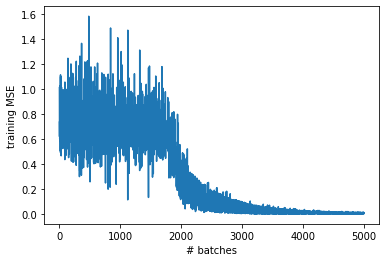

In [11]:
plt.plot(np.arange(1, nbatches+1), losses)
plt.xlabel("# batches")
plt.ylabel("training MSE")

Hopefully you have managed to produce a learning curve which after around 2000 batches has near zero error. We can also check our model by runing the same code as before to see explicitly how the predictions match up to the target values. 

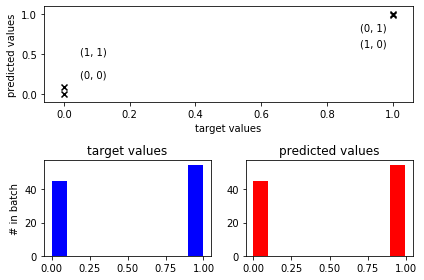

In [13]:
inputs, targets = generate_batch(chosen_dataset, batch_size=100)
preds, _, _ = nn.forward(inputs) #prediction made by model

_, inds = np.unique(inputs, return_index=True, axis=0)


# plot target vs predictions along with a histogram of each
fig = plt.figure()
ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=2)
plt.scatter(targets[inds], preds[inds], marker='x', c='black')

yup = 0.1
ydown = -0.1
for i in inds:
    coord = '({}, {})'.format(inputs[i][0], inputs[i][1])
    if np.isclose(preds[i], 0, atol=0.1):
        yup = 2 * yup
        yoffset = yup
    else:
        ydown = 2 * ydown
        yoffset = ydown
    
    xoffset = 0.05 if targets[i] == 0 else -0.1
    plt.text(targets[i] + xoffset, preds[i] + yoffset, coord)
plt.xlabel('target values')
plt.ylabel('predicted values')
plt.ylim([np.min(preds) - 0.1, np.max(preds) + 0.1])
ax2 = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
plt.hist(targets, color='blue')
ax2.set_title('target values')
plt.ylabel('# in batch')
ax3 = plt.subplot2grid((2,2), (1,1), rowspan=1, colspan=1, sharey=ax2)
plt.hist(preds, color='red')
ax3.set_title('predicted values')

fig.tight_layout()

We could also see how well our trained model performs across tasks by running the code below. One would expect it to perform the task for which it was trained well, but poorly for the others.

Text(0, 0.5, 'test MSE')

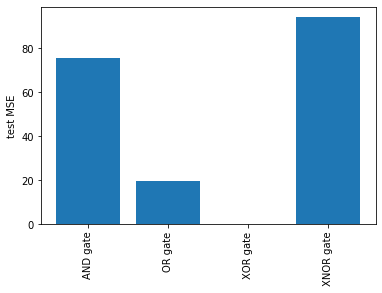

In [14]:
dataset_names = ['AND gate', 'OR gate', 'XOR gate', 'XNOR gate']
test_scores = [test(nn, dataset) for dataset in [dataset_and, 
                            dataset_or, dataset_xor, dataset_xnor]]

x = range(4)
plt.bar(x, test_scores)
plt.xticks(x, dataset_names, rotation='vertical')
plt.ylabel("test MSE")

## 1.8 The other datasets
Redo the previous section but now training the network with the AND, OR and XNOR datasets. Does the network learn some better than others?

# 2. Relating to biology

Congratulations on making it this far! By now you should have been able to build and train a one-hidden-layer neural network to mimic any of the AND, OR, XOR, XNOR gating operations. This part 2 is about comparing backprop to what we know about how learning takes place in the brain, as discussed in the lectures.

We want this part to be as open as possible - any ideas or insights you have are valuable. Some of the main issues (as talked about in class) will now be divided into the following subsections. Consider the extent of each issue; that is, to what extent the issue disqualifies backpropogation (or some approximation of it) as a realistic learning mechanism of the brain. For issues 1, 2, it should be possible to amend the code above and consider the resulting difference in performance from the 'pure' backpropagation algorithm as already tested. For 3-6 simply make your own prediction based on what you think the brain might be capable of.    

## 2.1 Weight transport problem

<div>
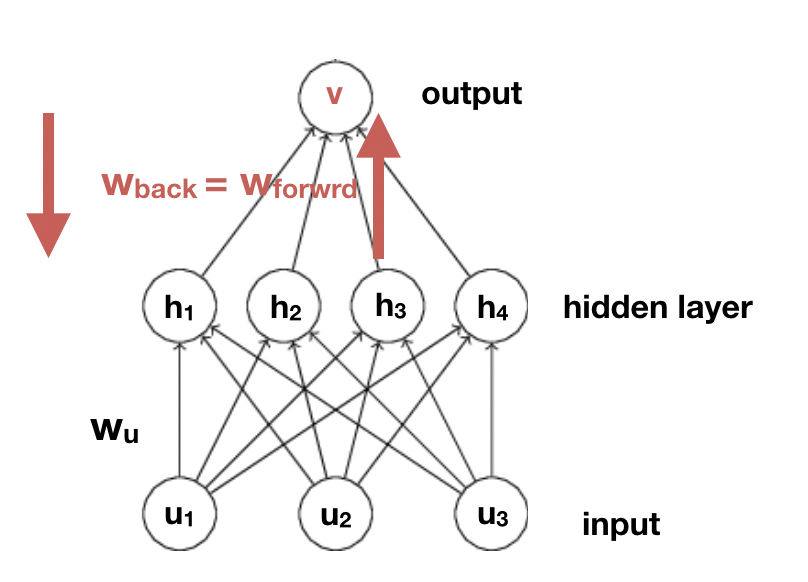
</div>

In the backpropagation algorithm error signals from one layer of neurons are propagated down to the layer of neurons beneath via the transpose of their feedforward connection weight matrix (this comes from the gradient calculations for matrix multiplication as shown in the 'backpropagating gradients' section). How the backward, 'top-down' connections match perfectly to the feedforward connections is known as the weight transport problem. How important is it that these forward and backward matrices align? To test this, consider what happens when you change the backpropagation code so that the backward weights are instead random and fixed (this was actually the basis of *feedback alignment* as described [here](https://www.nature.com/articles/ncomms13276)).

[Type your answer here]


## 2.2 Derivative of activation functions

<div>
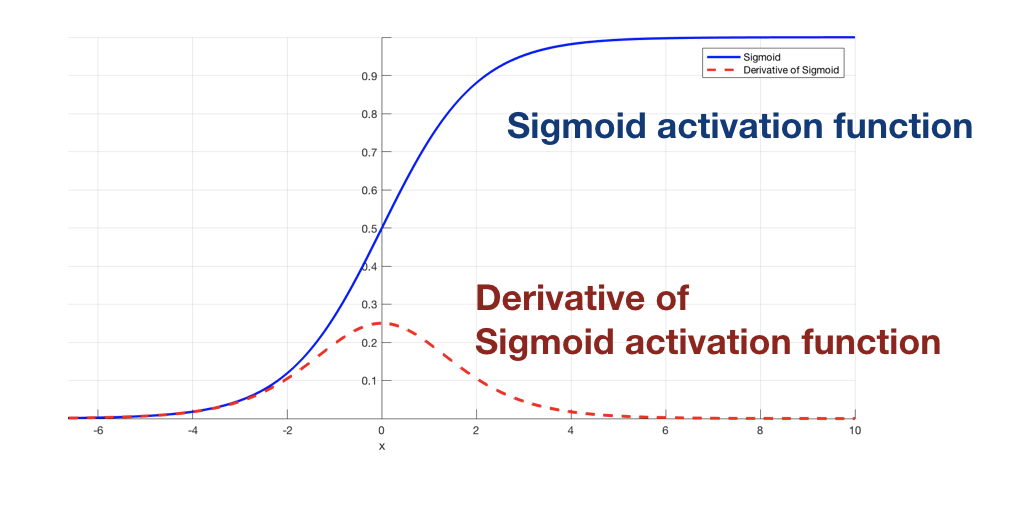
</div>

When a non-linearity is involved in a neural network, the backpropagation alogirthm requires knowledge of the derivative of that non-linearity. How important is this knowledge? What happens if you take it away (that is, if you no longer perform element wise multiplication step with it as required in backprop)?


[Type your answer here]

## 2.3 Two phase learning

<div>
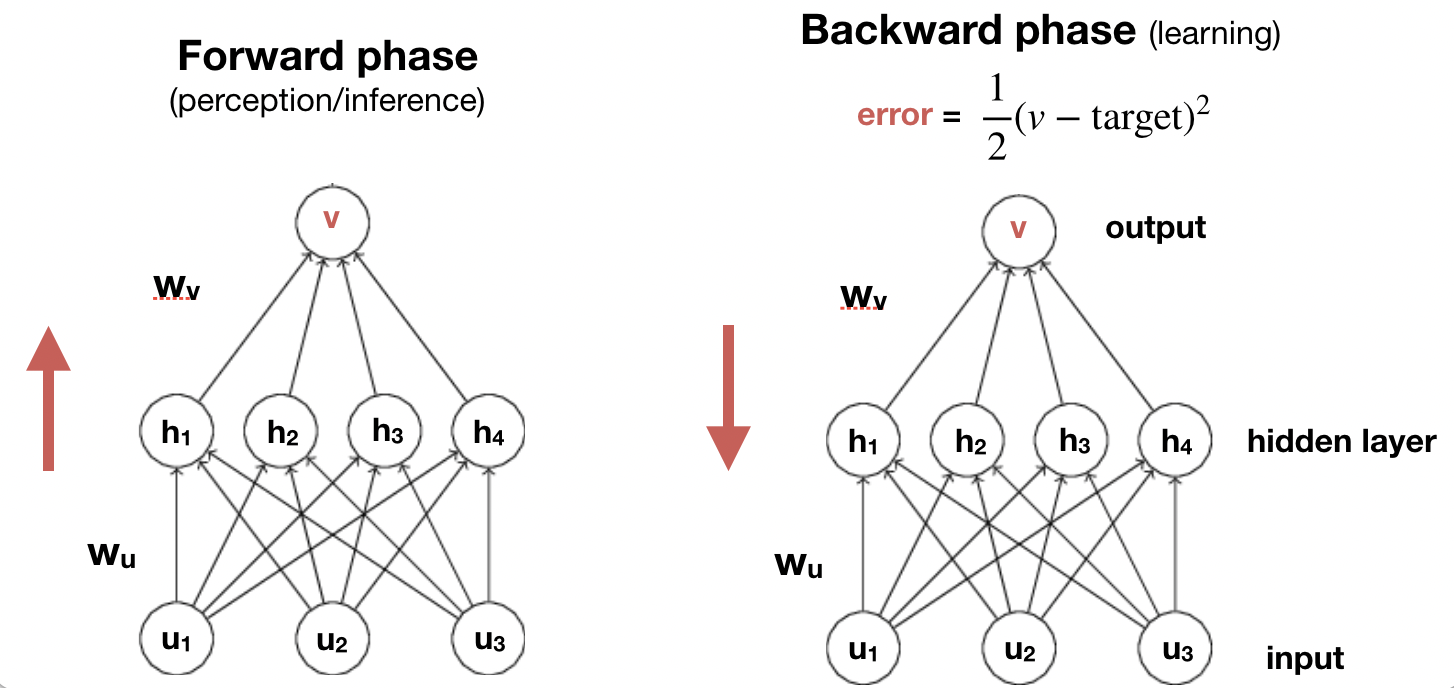
</div>

The backpropogation algorithm is divided into two phases: the forward phase (where the input is propogated up the network to form an output) and the backward phase (where the error signal propogated backwards and weights are adjusted accordingly). An artificial neural network performs each phase alternatively; they do not happen at the same time! Is this a realistic constraint of the brain? Could backpropogation still be implemented with both phases occuring simultaneously? If you're particularly interested in this, a potential solution to this issue is offered in [Sacramento et al.](http://papers.neurips.cc/paper/8089-dendritic-cortical-microcircuits-approximate-the-backpropagation-algorithm.pdf) as discussed in the lectures.

[Type here your answer]

## 2.4 Separate error network

<div>
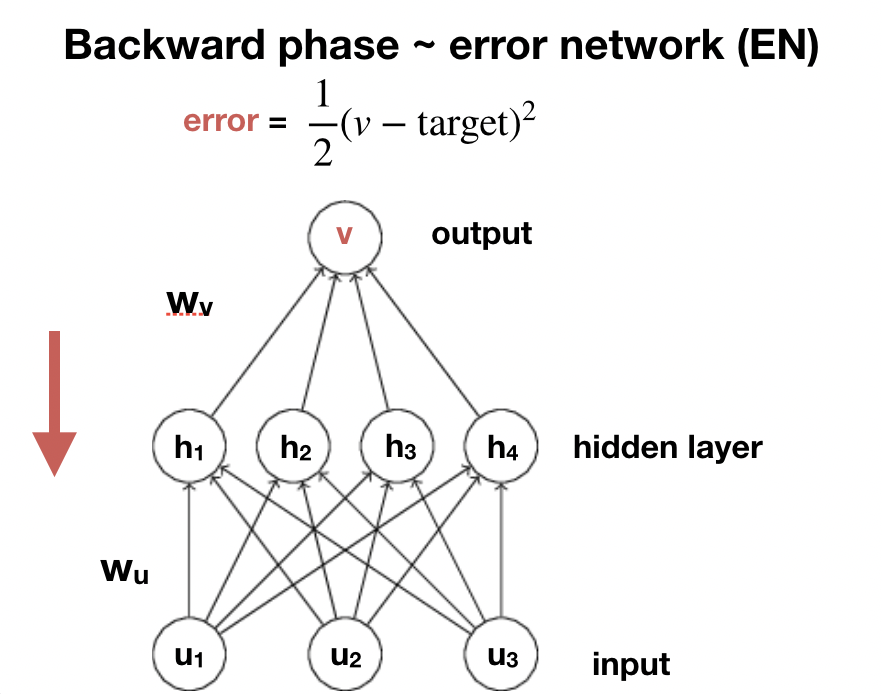
</div>

To backpropagate an error, we first need an (original) error signal being defined. But where could this error be defined in the brain? Does it make sense for there to be a specialised brain region dedicated to producing error signals?

[Type here your answer]

## 2.5 Non-local learning rules

<div>
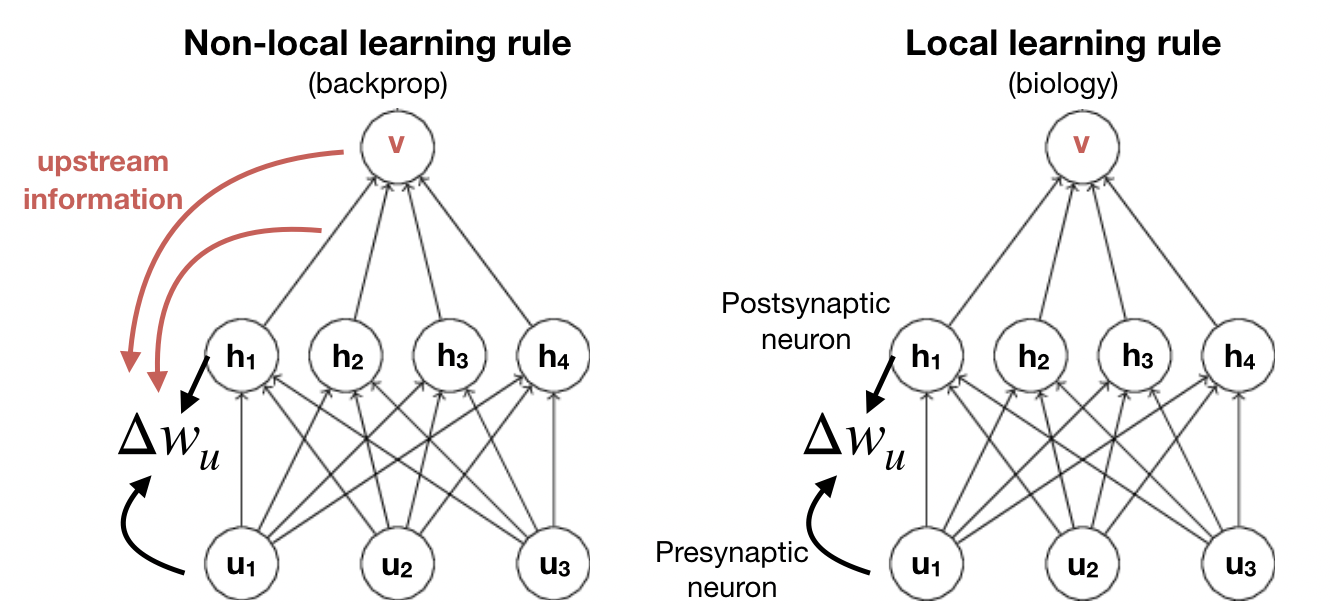
</div>

Consider the final terms necessary to update the synapse $W_{ji}$ from neuron $i$ to $j$. What information does the synapse need? Is it reasonable that the synapse would be able to have access to this information in real life?



[Type here your answer]

## 2.6 Target

For supervised learning tasks such as the one above, a key assumption is that for each input we have access to some associated target for the network. In machine learning we often refer to the provided of the target as a 'teacher'. Is it fair to say the brain has access to such targets? What would be the teacher? More generally how do you think the brain might have encode/compute cost functions (e.g. as used in unsupervised or reinforcement learning)?

[Type here your answer]